In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

In [19]:
path = "../../Dataset/"
x_train = pd.read_csv(path + "X_train_winsorized.csv")
y_train = pd.read_csv(path + "Y_train_winsorized.csv")
x_validation = pd.read_csv(path + "X_validation.csv")
y_validation = pd.read_csv(path + "Y_validation.csv")
x_test = pd.read_csv(path + "X_test.csv")
y_test = pd.read_csv(path + "Y_test.csv")

In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((1145381, 47), (1145381, 1), (41292, 47), (41292, 1), (66753, 47), (66753, 1))

In [22]:
x_train = x_train.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey', 'sic_2'])
x_test = x_test.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey', 'sic_2'])
x_validation = x_validation.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey', 'sic_2'])

In [23]:
x_train.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,0.089239,0.011089,0.677551,0.332808,1.411466,0.027249,-0.148249,0.079108,-5.559146,1.222586,...,197946.597222,0.000000,-5.000000,-0.000000,1.000000,-5.251700e+06,-2.189250e+07,-2.185540e+07,-149041.103448,-297211.000000
1,0.089239,0.011089,4.107086,0.630494,0.693956,-0.033837,0.002636,0.010524,1.950683,0.170605,...,225.291785,1.473649,24.661017,0.000000,1.000000,5.736944e+01,-2.573694e+01,-2.401616e+01,-0.254513,8.362963
2,0.089239,0.011089,1.790834,-0.166384,0.950492,0.000639,0.003601,-0.001063,-1.295504,-0.038405,...,155.876643,-7.355720,-40.625000,-0.000000,1.000000,2.601585e+01,-6.971004e+01,-6.409370e+01,-0.636439,2.678535
3,0.089239,0.011089,0.722350,-0.343402,0.000000,0.000000,0.000159,0.000162,-1.684633,-0.221586,...,12.503481,0.491920,48.828125,0.375000,0.625000,3.849395e+01,-4.496380e+01,-4.475246e+01,-0.399279,3.216189
4,0.089239,0.011089,3.885435,-1.867683,0.576706,-0.163337,0.004104,0.001007,2.640686,-0.233267,...,234.784192,1.528298,-63.651316,-0.447368,1.447368,2.460309e+01,-6.840586e+01,-6.626797e+01,-0.505033,2.533648


In [24]:
x_validation.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,0.192826,-0.005433,6.620916,0.178174,0.550612,-0.002232,0.003326,-0.000411,0.316299,-0.033206,...,95.194415,3.624247,65.493151,0.424658,0.575342,26.232852,-68.907790,-66.675149,-3.394249,6230.250000
1,0.192826,-0.005433,8.170784,0.138061,1.443111,-0.053335,0.006510,0.000160,2.161285,0.169988,...,243.156600,0.865778,59.577114,0.310945,0.689055,32.969402,-55.784640,-53.137154,-0.643514,15.286624
2,0.192826,-0.005433,3.647221,0.064328,0.402012,0.029748,0.004202,-0.001154,-0.379640,0.071717,...,122.714653,1.060730,-64.823529,-0.000000,1.000000,11.919292,-86.147801,-83.372346,-6.305507,9.041899
3,0.192826,-0.005433,6.368879,0.310434,0.000000,0.000000,0.000164,0.003938,-0.321386,0.179888,...,0.000000,0.014399,38.973684,0.473684,0.526316,51.592925,-3.147638,29.762216,-0.003530,2.263764
4,0.192826,-0.005433,2.666948,-0.377029,1.121218,0.046178,-0.000330,-0.004651,-1.295098,0.011449,...,320.246020,0.599136,51.827586,0.241379,0.758621,28.136813,-65.478907,-61.947489,-0.579472,8.210410


In [25]:
x_test.head()

,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,sizetrend,...,day_sales_outstanding,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio
0,0.200978,-0.010836,4.212361,-0.771966,0.672296,0.041557,0.008952,0.004579,1.825458,-0.261288,...,156.519168,2.065652,91.320000,0.720000,0.280000,32.407521,-5.837426e+01,-5.525032e+01,-0.487270,16.573864
1,0.222340,-0.010290,1.078135,0.261917,0.403060,0.273987,-0.095313,0.038781,0.683895,-0.896192,...,301.480262,0.000000,-6.005455,-0.000000,1.000000,54.041932,-2.189250e+07,-2.185540e+07,-5.149795,-123.957746
2,0.200978,-0.010836,6.346572,0.392117,0.037157,0.010814,0.001485,0.000398,4.538477,-0.076843,...,0.000000,4.140367,82.170732,0.000000,1.000000,73.893328,1.541784e+01,3.206651e+01,0.032206,9.426471
3,0.200978,-0.010836,1.167333,0.019646,0.049827,0.137677,0.021205,0.013787,-1.072076,-0.951811,...,342.352131,4.017040,-8.250000,-0.000000,1.000000,11.236388,-8.896010e+01,-8.467047e+01,-2.748964,-0.597765
4,0.200978,-0.010836,5.745800,0.868386,1.096926,0.063157,0.002625,0.001695,0.891056,0.097058,...,202.770320,0.625057,-39.380435,-0.101449,1.101449,41.081280,-3.902170e+01,-2.975359e+01,-0.126611,4.745614


In [26]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [27]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'precision', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-03 20:09:22,201] A new study created in memory with name: no-name-9ab7cd8f-c9b3-478f-86a2-c41b11370f3e
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:09:30,993] Trial 0 finished with value: 0.7690906910148863 and parameters: {'num_leaves': 59, 'lambda_l1': 0.006095477680447287, 'lambda_l2': 0.0015496567035092068, 'feature_fraction': 0.8359913924118234, 'min_child_samples': 62, 'learning_rate': 0.11354275534905346, 'max_depth': 203, 'num_boost_round': 301}. Best is trial 0 with value: 0.7690906910148863.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:09:54,676] Trial 1 finished with value: 0.9658726607310506 and parameters: {'num_leaves': 225, 'lambda_l1': 0.002091362752263156, 'lambda_l2': 0.027689888288351252, 'feature_fraction': 0.6907037698846445, 'min_child_samples': 21, 'learning_rate': 0.003417712914989824, 'max_depth': 119, 'num_boost_round': 231}. Best is trial 1 with value: 0.9658726607310506.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:10:05,761] Trial 2 finished with value: 0.9640589800330595 and parameters: {'num_leaves': 252, 'lambda_l1': 7.732503766890653e-07, 'lambda_l2': 0.007444027450484665, 'feature_fraction': 0.4161622463573931, 'min_child_samples': 5, 'learning_rate': 7.937476058625614e-06, 'max_depth': 248, 'num_boost_round': 120}. Best is trial 1 with value: 0.9658726607310506.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:10:21,971] Trial 3 finished with value: 0.9607775790671053 and parameters: {'num_leaves': 171, 'lambda_l1': 2.095852937992445e-05, 'lambda_l2': 0.015136025157083798, 'feature_fraction': 0.7373140991458307, 'min_child_samples': 65, 'learning_rate': 2.626042001479013e-05, 'max_depth': 55, 'num_boost_round': 214}. Best is trial 1 with value: 0.9658726607310506.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:10:33,582] Trial 4 finished with value: 0.9633331801218336 and parameters: {'num_leaves': 127, 'lambda_l1': 0.11157940608812789, 'lambda_l2': 0.048311995493953576, 'feature_fraction': 0.47721775643251785, 'min_child_samples': 85, 'learning_rate': 0.00033534472259329966, 'max_depth': 154, 'num_boost_round': 196}. Best is trial 1 with value: 0.9658726607310506.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:10:59,346] Trial 5 finished with value: 0.9527500482901122 and parameters: {'num_leaves': 133, 'lambda_l1': 5.6647267345616526e-05, 'lambda_l2': 1.7685581181593109, 'feature_fraction': 0.8991497062085196, 'min_child_samples': 35, 'learning_rate': 2.692481200291034e-07, 'max_depth': 256, 'num_boost_round': 409}. Best is trial 1 with value: 0.9658726607310506.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-11-03 20:11:03,005] Trial 6 finished with value: 0.459189252225951 and parameters: {'num_leaves': 23, 'lambda_l1': 6.146293346175234e-08, 'lambda_l2': 0.002428527674886024, 'feature_fraction': 0.8415556764034393, 'min_child_samples': 66, 'learning_rate': 1.2092629748488213, 'max_depth': 97, 'num_boost_round': 438}. Best is trial 1 with value: 0.9658726607310506.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:11:11,629] Trial 7 finished with value: 0.7905647863373836 and parameters: {'num_leaves': 111, 'lambda_l1': 1.5952437615391084e-07, 'lambda_l2': 0.008318551396210625, 'feature_fraction': 0.42188482518675163, 'min_child_samples': 61, 'learning_rate': 0.30453049862405956, 'max_depth': 85, 'num_boost_round': 184}. Best is trial 1 with value: 0.9658726607310506.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:11:38,654] Trial 8 finished with value: 0.9605297657972294 and parameters: {'num_leaves': 121, 'lambda_l1': 1.6122992652910563e-05, 'lambda_l2': 0.003004355121880807, 'feature_fraction': 0.6188668924368661, 'min_child_samples': 92, 'learning_rate': 1.8730737542034094e-08, 'max_depth': 117, 'num_boost_round': 460}. Best is trial 1 with value: 0.9658726607310506.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:12:07,697] Trial 9 finished with value: 0.9662628514850656 and parameters: {'num_leaves': 163, 'lambda_l1': 0.3594852272681164, 'lambda_l2': 3.215804723244793e-07, 'feature_fraction': 0.7085618232749376, 'min_child_samples': 33, 'learning_rate': 0.0023697896609649327, 'max_depth': 204, 'num_boost_round': 369}. Best is trial 9 with value: 0.9662628514850656.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:12:13,027] Trial 10 finished with value: 0.9623416658863644 and parameters: {'num_leaves': 189, 'lambda_l1': 9.26341785966799, 'lambda_l2': 1.1283571013798466e-07, 'feature_fraction': 0.9948963462929722, 'min_child_samples': 41, 'learning_rate': 0.0063338421522050195, 'max_depth': 3, 'num_boost_round': 349}. Best is trial 9 with value: 0.9662628514850656.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:12:42,432] Trial 11 finished with value: 0.9682607421045905 and parameters: {'num_leaves': 249, 'lambda_l1': 0.014058844609355949, 'lambda_l2': 1.3723249918167459e-05, 'feature_fraction': 0.6498496588891414, 'min_child_samples': 19, 'learning_rate': 0.008550550874156121, 'max_depth': 165, 'num_boost_round': 284}. Best is trial 11 with value: 0.9682607421045905.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:13:12,927] Trial 12 finished with value: 0.9718281088528453 and parameters: {'num_leaves': 198, 'lambda_l1': 0.11332246490399994, 'lambda_l2': 3.8101671832617675e-06, 'feature_fraction': 0.5792440276431979, 'min_child_samples': 19, 'learning_rate': 0.014157731197409854, 'max_depth': 176, 'num_boost_round': 356}. Best is trial 12 with value: 0.9718281088528453.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-11-03 20:13:15,888] Trial 13 finished with value: 0.7948870125333971 and parameters: {'num_leaves': 215, 'lambda_l1': 0.014764435681865678, 'lambda_l2': 2.560935193429829e-05, 'feature_fraction': 0.5693257035959172, 'min_child_samples': 12, 'learning_rate': 4.6277489222217065, 'max_depth': 168, 'num_boost_round': 296}. Best is trial 12 with value: 0.9718281088528453.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:13:43,997] Trial 14 finished with value: 0.9546442362498534 and parameters: {'num_leaves': 254, 'lambda_l1': 0.000535977085958444, 'lambda_l2': 9.456060594435301e-06, 'feature_fraction': 0.547753762286006, 'min_child_samples': 22, 'learning_rate': 0.05501829894980535, 'max_depth': 177, 'num_boost_round': 287}. Best is trial 12 with value: 0.9718281088528453.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:14:26,905] Trial 15 finished with value: 0.970016921007253 and parameters: {'num_leaves': 210, 'lambda_l1': 0.09579921535337874, 'lambda_l2': 3.735545323837267e-05, 'feature_fraction': 0.6254993234959716, 'min_child_samples': 46, 'learning_rate': 0.026013069464133284, 'max_depth': 212, 'num_boost_round': 498}. Best is trial 12 with value: 0.9718281088528453.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped train

[I 2023-11-03 20:14:30,929] Trial 16 finished with value: 0.722031003296643 and parameters: {'num_leaves': 201, 'lambda_l1': 0.6726566554253852, 'lambda_l2': 1.779133775328172e-08, 'feature_fraction': 0.5297088617661718, 'min_child_samples': 51, 'learning_rate': 7.656579182749205, 'max_depth': 225, 'num_boost_round': 496}. Best is trial 12 with value: 0.9718281088528453.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:14:59,518] Trial 17 finished with value: 0.9608357693645247 and parameters: {'num_leaves': 167, 'lambda_l1': 6.899546659600772, 'lambda_l2': 0.00010618955176883738, 'feature_fraction': 0.6130518023700327, 'min_child_samples': 45, 'learning_rate': 0.05352195449732663, 'max_depth': 203, 'num_boost_round': 396}. Best is trial 12 with value: 0.9718281088528453.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped train

[I 2023-11-03 20:15:07,866] Trial 18 finished with value: 0.6042203421314087 and parameters: {'num_leaves': 89, 'lambda_l1': 0.06165209571353288, 'lambda_l2': 1.891616076587921e-06, 'feature_fraction': 0.5130773719652045, 'min_child_samples': 29, 'learning_rate': 0.586852301878809, 'max_depth': 137, 'num_boost_round': 497}. Best is trial 12 with value: 0.9718281088528453.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:15:31,248] Trial 19 finished with value: 0.9711174322461711 and parameters: {'num_leaves': 152, 'lambda_l1': 0.0015290204466505643, 'lambda_l2': 1.2470007189239507e-06, 'feature_fraction': 0.5846418468189863, 'min_child_samples': 79, 'learning_rate': 0.03126669077427898, 'max_depth': 226, 'num_boost_round': 338}. Best is trial 12 with value: 0.9718281088528453.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:15:54,753] Trial 20 finished with value: 0.9639681927228463 and parameters: {'num_leaves': 158, 'lambda_l1': 0.0009201324779703132, 'lambda_l2': 1.2622204649099043e-06, 'feature_fraction': 0.47146338603477955, 'min_child_samples': 82, 'learning_rate': 0.00015659538544596626, 'max_depth': 229, 'num_boost_round': 341}. Best is trial 12 with value: 0.9718281088528453.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:16:31,866] Trial 21 finished with value: 0.9735143691810889 and parameters: {'num_leaves': 194, 'lambda_l1': 0.025631415290381352, 'lambda_l2': 5.49698976096088e-05, 'feature_fraction': 0.5885706507000287, 'min_child_samples': 53, 'learning_rate': 0.025417933117870998, 'max_depth': 188, 'num_boost_round': 446}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-11-03 20:16:41,325] Trial 22 finished with value: 0.8059688572935543 and parameters: {'num_leaves': 184, 'lambda_l1': 0.0059892839482976025, 'lambda_l2': 0.00036272166094711994, 'feature_fraction': 0.5806645059098878, 'min_child_samples': 76, 'learning_rate': 0.31949404481622573, 'max_depth': 184, 'num_boost_round': 406}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:17:12,147] Trial 23 finished with value: 0.9712239838801243 and parameters: {'num_leaves': 224, 'lambda_l1': 0.00010380186517733618, 'lambda_l2': 4.991017519850557e-06, 'feature_fraction': 0.5710196411769768, 'min_child_samples': 73, 'learning_rate': 0.01444556787772827, 'max_depth': 189, 'num_boost_round': 330}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:17:36,176] Trial 24 finished with value: 0.9649883391487226 and parameters: {'num_leaves': 230, 'lambda_l1': 0.00033574123442592883, 'lambda_l2': 0.00020989158174581894, 'feature_fraction': 0.49920997513270815, 'min_child_samples': 57, 'learning_rate': 0.0007749182039856398, 'max_depth': 188, 'num_boost_round': 257}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:18:11,793] Trial 25 finished with value: 0.9719442520331704 and parameters: {'num_leaves': 195, 'lambda_l1': 0.00014051410297864628, 'lambda_l2': 5.652067112362897e-06, 'feature_fraction': 0.5426268905415553, 'min_child_samples': 74, 'learning_rate': 0.015523602204947548, 'max_depth': 141, 'num_boost_round': 434}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:18:50,591] Trial 26 finished with value: 0.9655112683576025 and parameters: {'num_leaves': 192, 'lambda_l1': 1.1070826959312645, 'lambda_l2': 4.923859942760161e-05, 'feature_fraction': 0.6570326999845173, 'min_child_samples': 93, 'learning_rate': 0.002004482366304437, 'max_depth': 150, 'num_boost_round': 445}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:19:17,312] Trial 27 finished with value: 0.8254615385638094 and parameters: {'num_leaves': 148, 'lambda_l1': 0.02257636572884803, 'lambda_l2': 3.425579269403173e-06, 'feature_fraction': 0.5259336055480126, 'min_child_samples': 54, 'learning_rate': 0.12038421936397464, 'max_depth': 133, 'num_boost_round': 463}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:19:35,381] Trial 28 finished with value: 0.9680559246032281 and parameters: {'num_leaves': 93, 'lambda_l1': 0.003978218872618343, 'lambda_l2': 2.4713178802498487e-07, 'feature_fraction': 0.4602996659445278, 'min_child_samples': 99, 'learning_rate': 0.0070846181449612765, 'max_depth': 78, 'num_boost_round': 376}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-11-03 20:19:48,816] Trial 29 finished with value: 0.8034779279524821 and parameters: {'num_leaves': 179, 'lambda_l1': 0.004720886901797323, 'lambda_l2': 0.00048544167908532994, 'feature_fraction': 0.5260911016588254, 'min_child_samples': 70, 'learning_rate': 0.22010219710952816, 'max_depth': 148, 'num_boost_round': 426}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Ligh

[I 2023-11-03 20:19:52,135] Trial 30 finished with value: 0.7682715397166942 and parameters: {'num_leaves': 46, 'lambda_l1': 0.02364657905073272, 'lambda_l2': 7.351431337285796e-05, 'feature_fraction': 0.7424395765980446, 'min_child_samples': 60, 'learning_rate': 1.7577657349374383, 'max_depth': 105, 'num_boost_round': 378}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:20:22,934] Trial 31 finished with value: 0.9720868431903724 and parameters: {'num_leaves': 231, 'lambda_l1': 0.0002746900275326623, 'lambda_l2': 1.5207990804793337e-05, 'feature_fraction': 0.575518422820191, 'min_child_samples': 71, 'learning_rate': 0.020745130251149463, 'max_depth': 195, 'num_boost_round': 321}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:20:50,510] Trial 32 finished with value: 0.9143774051277357 and parameters: {'num_leaves': 234, 'lambda_l1': 0.0010738490787756136, 'lambda_l2': 1.1855976368848387e-05, 'feature_fraction': 0.5499476838141898, 'min_child_samples': 69, 'learning_rate': 0.09895092278658776, 'max_depth': 165, 'num_boost_round': 309}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:21:27,822] Trial 33 finished with value: 0.9728287635471096 and parameters: {'num_leaves': 204, 'lambda_l1': 0.0002045735910213844, 'lambda_l2': 2.081186675615429e-05, 'feature_fraction': 0.5877321726226752, 'min_child_samples': 87, 'learning_rate': 0.020737195027176317, 'max_depth': 196, 'num_boost_round': 471}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:22:14,732] Trial 34 finished with value: 0.9666719404344079 and parameters: {'num_leaves': 237, 'lambda_l1': 0.0002511482468954041, 'lambda_l2': 2.9459492488989647e-05, 'feature_fraction': 0.666765023823536, 'min_child_samples': 85, 'learning_rate': 0.0018048802577922156, 'max_depth': 195, 'num_boost_round': 470}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:22:50,060] Trial 35 finished with value: 0.9670499043409438 and parameters: {'num_leaves': 212, 'lambda_l1': 6.624067114864558e-06, 'lambda_l2': 0.0007599932050639696, 'feature_fraction': 0.4904100431051783, 'min_child_samples': 88, 'learning_rate': 0.04028180556313441, 'max_depth': 209, 'num_boost_round': 422}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:23:37,499] Trial 36 finished with value: 0.9716758786663686 and parameters: {'num_leaves': 241, 'lambda_l1': 0.00011056597456904227, 'lambda_l2': 0.00014643935180092362, 'feature_fraction': 0.607252787914773, 'min_child_samples': 100, 'learning_rate': 0.005245195205350629, 'max_depth': 229, 'num_boost_round': 473}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:23:50,823] Trial 37 finished with value: 0.9639142996281329 and parameters: {'num_leaves': 217, 'lambda_l1': 4.803040292736517e-06, 'lambda_l2': 9.598116814461129e-05, 'feature_fraction': 0.6979331084198451, 'min_child_samples': 79, 'learning_rate': 0.00047860885194372373, 'max_depth': 118, 'num_boost_round': 143}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:24:09,113] Trial 38 finished with value: 0.8312817078954381 and parameters: {'num_leaves': 201, 'lambda_l1': 0.0024624120937319443, 'lambda_l2': 1.3683365798133748e-05, 'feature_fraction': 0.42389383315924, 'min_child_samples': 66, 'learning_rate': 0.1154378414626885, 'max_depth': 251, 'num_boost_round': 248}. Best is trial 21 with value: 0.9735143691810889.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:24:39,538] Trial 39 finished with value: 0.974621955372529 and parameters: {'num_leaves': 143, 'lambda_l1': 3.949384734355306e-05, 'lambda_l2': 0.0010086420657917892, 'feature_fraction': 0.6384545386429703, 'min_child_samples': 74, 'learning_rate': 0.015859395051568213, 'max_depth': 53, 'num_boost_round': 438}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:25:06,738] Trial 40 finished with value: 0.9630182735102572 and parameters: {'num_leaves': 140, 'lambda_l1': 3.43058818513827e-05, 'lambda_l2': 0.0003549516814556702, 'feature_fraction': 0.6354986078342649, 'min_child_samples': 91, 'learning_rate': 0.00015341991934904174, 'max_depth': 38, 'num_boost_round': 400}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:25:39,430] Trial 41 finished with value: 0.9695051977634414 and parameters: {'num_leaves': 172, 'lambda_l1': 8.801371112491427e-05, 'lambda_l2': 0.0010516420378143612, 'feature_fraction': 0.5954758944030029, 'min_child_samples': 74, 'learning_rate': 0.036542178354121116, 'max_depth': 49, 'num_boost_round': 445}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:25:43,527] Trial 42 finished with value: 0.9601748785814692 and parameters: {'num_leaves': 2, 'lambda_l1': 0.00029490671483926124, 'lambda_l2': 0.002349803903911947, 'feature_fraction': 0.6094677517858273, 'min_child_samples': 82, 'learning_rate': 0.01593150857604143, 'max_depth': 12, 'num_boost_round': 428}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:26:11,811] Trial 43 finished with value: 0.9690706579781818 and parameters: {'num_leaves': 112, 'lambda_l1': 2.2226888225430944e-05, 'lambda_l2': 0.00021137014306777727, 'feature_fraction': 0.5504760494918208, 'min_child_samples': 65, 'learning_rate': 0.003214090336975652, 'max_depth': 79, 'num_boost_round': 473}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:26:50,224] Trial 44 finished with value: 0.9643487919304896 and parameters: {'num_leaves': 179, 'lambda_l1': 0.00014406899881724564, 'lambda_l2': 0.04787921444306583, 'feature_fraction': 0.6453857901217293, 'min_child_samples': 70, 'learning_rate': 0.0010495314952827118, 'max_depth': 63, 'num_boost_round': 450}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:27:32,807] Trial 45 finished with value: 0.9718570734235725 and parameters: {'num_leaves': 223, 'lambda_l1': 0.0006351516939769474, 'lambda_l2': 0.00707107174646366, 'feature_fraction': 0.6851001675561992, 'min_child_samples': 62, 'learning_rate': 0.00758235216190879, 'max_depth': 143, 'num_boost_round': 415}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more

[I 2023-11-03 20:27:39,546] Trial 46 finished with value: 0.7894165547811199 and parameters: {'num_leaves': 205, 'lambda_l1': 3.9362224971707076e-05, 'lambda_l2': 3.673195017965209e-05, 'feature_fraction': 0.5493695044506232, 'min_child_samples': 95, 'learning_rate': 0.6280477871263772, 'max_depth': 104, 'num_boost_round': 388}. Best is trial 39 with value: 0.974621955372529.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:28:22,455] Trial 47 finished with value: 0.9740699666271166 and parameters: {'num_leaves': 193, 'lambda_l1': 0.0016327608547038383, 'lambda_l2': 7.344768865147023e-05, 'feature_fraction': 0.6045197135816839, 'min_child_samples': 85, 'learning_rate': 0.016395082428419947, 'max_depth': 125, 'num_boost_round': 480}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:28:49,026] Trial 48 finished with value: 0.8412772388046237 and parameters: {'num_leaves': 133, 'lambda_l1': 0.002894365923813897, 'lambda_l2': 0.001098385534113615, 'feature_fraction': 0.6295827622778957, 'min_child_samples': 87, 'learning_rate': 0.12938449373336197, 'max_depth': 243, 'num_boost_round': 482}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:28:59,707] Trial 49 finished with value: 0.963361883536595 and parameters: {'num_leaves': 83, 'lambda_l1': 0.0016562007874973404, 'lambda_l2': 7.932247563135427e-05, 'feature_fraction': 0.5912899360522849, 'min_child_samples': 81, 'learning_rate': 0.003417977248024307, 'max_depth': 21, 'num_boost_round': 189}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:29:17,222] Trial 50 finished with value: 0.9521111183496159 and parameters: {'num_leaves': 244, 'lambda_l1': 0.0004650761036266003, 'lambda_l2': 1.97061594067517e-05, 'feature_fraction': 0.667891418172866, 'min_child_samples': 48, 'learning_rate': 0.06649711204909335, 'max_depth': 161, 'num_boost_round': 165}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:29:56,817] Trial 51 finished with value: 0.972587882781047 and parameters: {'num_leaves': 191, 'lambda_l1': 0.0002104585506075186, 'lambda_l2': 7.1153807948518815e-06, 'feature_fraction': 0.5648337522358978, 'min_child_samples': 75, 'learning_rate': 0.020759058137440972, 'max_depth': 124, 'num_boost_round': 451}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:30:35,517] Trial 52 finished with value: 0.9720886475406801 and parameters: {'num_leaves': 187, 'lambda_l1': 6.235512454958574e-05, 'lambda_l2': 2.5943973177251318e-05, 'feature_fraction': 0.5645295806366962, 'min_child_samples': 77, 'learning_rate': 0.02332083475287347, 'max_depth': 126, 'num_boost_round': 454}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:31:14,572] Trial 53 finished with value: 0.9716688037138468 and parameters: {'num_leaves': 170, 'lambda_l1': 1.3408871742332921e-05, 'lambda_l2': 5.357692963249159e-05, 'feature_fraction': 0.6265894078979684, 'min_child_samples': 77, 'learning_rate': 0.007668967628524429, 'max_depth': 129, 'num_boost_round': 456}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:31:54,513] Trial 54 finished with value: 0.9713555590038695 and parameters: {'num_leaves': 186, 'lambda_l1': 6.223592743664635e-05, 'lambda_l2': 0.00012727655647925168, 'feature_fraction': 0.5947849837687911, 'min_child_samples': 87, 'learning_rate': 0.032348788028029714, 'max_depth': 95, 'num_boost_round': 479}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:32:25,733] Trial 55 finished with value: 0.9595764278156363 and parameters: {'num_leaves': 156, 'lambda_l1': 0.0008663400738729979, 'lambda_l2': 6.556394687149281e-06, 'feature_fraction': 0.5579341795394798, 'min_child_samples': 39, 'learning_rate': 0.07326043473761247, 'max_depth': 124, 'num_boost_round': 487}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:33:01,212] Trial 56 finished with value: 0.9733802299805909 and parameters: {'num_leaves': 173, 'lambda_l1': 0.007878814161847235, 'lambda_l2': 0.0005215590481718682, 'feature_fraction': 0.6071299667314182, 'min_child_samples': 84, 'learning_rate': 0.014064626214482458, 'max_depth': 109, 'num_boost_round': 458}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-11-03 20:33:14,486] Trial 57 finished with value: 0.8197638513800336 and parameters: {'num_leaves': 143, 'lambda_l1': 0.008132293271148902, 'lambda_l2': 0.000535056182254149, 'feature_fraction': 0.6185098011473471, 'min_child_samples': 84, 'learning_rate': 0.24612738031601392, 'max_depth': 108, 'num_boost_round': 439}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:33:45,747] Trial 58 finished with value: 0.973006444569504 and parameters: {'num_leaves': 123, 'lambda_l1': 0.008380449926357838, 'lambda_l2': 0.001287240257584588, 'feature_fraction': 0.598599527555725, 'min_child_samples': 96, 'learning_rate': 0.010412342037393623, 'max_depth': 90, 'num_boost_round': 500}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:34:20,126] Trial 59 finished with value: 0.9695260190163328 and parameters: {'num_leaves': 124, 'lambda_l1': 0.012394683698267274, 'lambda_l2': 0.004056320191557459, 'feature_fraction': 0.6417517948256137, 'min_child_samples': 96, 'learning_rate': 0.0046008130474250435, 'max_depth': 91, 'num_boost_round': 500}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:34:50,682] Trial 60 finished with value: 0.9729619056066482 and parameters: {'num_leaves': 113, 'lambda_l1': 0.002328237504945235, 'lambda_l2': 0.001153428436386906, 'feature_fraction': 0.6046561153352265, 'min_child_samples': 92, 'learning_rate': 0.009961175261271493, 'max_depth': 66, 'num_boost_round': 488}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:35:20,485] Trial 61 finished with value: 0.973323392945902 and parameters: {'num_leaves': 107, 'lambda_l1': 0.0024810656713051393, 'lambda_l2': 0.0016541889344615114, 'feature_fraction': 0.6042190963979607, 'min_child_samples': 89, 'learning_rate': 0.010160317244993803, 'max_depth': 64, 'num_boost_round': 485}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:35:47,474] Trial 62 finished with value: 0.9656534796515818 and parameters: {'num_leaves': 85, 'lambda_l1': 0.006426927971800315, 'lambda_l2': 0.0016332986444314058, 'feature_fraction': 0.602042260690943, 'min_child_samples': 90, 'learning_rate': 0.0018433317174533885, 'max_depth': 68, 'num_boost_round': 500}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:36:15,763] Trial 63 finished with value: 0.9710301586707675 and parameters: {'num_leaves': 102, 'lambda_l1': 0.0021614699811436265, 'lambda_l2': 0.01473930979611762, 'feature_fraction': 0.6162539998803277, 'min_child_samples': 96, 'learning_rate': 0.00986695901372785, 'max_depth': 61, 'num_boost_round': 484}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:36:43,856] Trial 64 finished with value: 0.9730068481741779 and parameters: {'num_leaves': 107, 'lambda_l1': 0.026515129565439995, 'lambda_l2': 0.0002608516561006633, 'feature_fraction': 0.6486109122217704, 'min_child_samples': 92, 'learning_rate': 0.008910806218910012, 'max_depth': 47, 'num_boost_round': 466}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:37:06,309] Trial 65 finished with value: 0.9682373805163975 and parameters: {'num_leaves': 69, 'lambda_l1': 0.04301851137967415, 'lambda_l2': 0.0002724193802062461, 'feature_fraction': 0.6562878669171249, 'min_child_samples': 94, 'learning_rate': 0.004499088736751547, 'max_depth': 44, 'num_boost_round': 464}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:37:36,762] Trial 66 finished with value: 0.9633358154229406 and parameters: {'num_leaves': 133, 'lambda_l1': 0.013528903536686517, 'lambda_l2': 0.0006571644827701088, 'feature_fraction': 0.6771101569681309, 'min_child_samples': 98, 'learning_rate': 0.0010547207032869424, 'max_depth': 28, 'num_boost_round': 435}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:37:58,119] Trial 67 finished with value: 0.9668737902543431 and parameters: {'num_leaves': 98, 'lambda_l1': 0.048566971351987086, 'lambda_l2': 0.003280842161770851, 'feature_fraction': 0.6444295197271415, 'min_child_samples': 89, 'learning_rate': 0.044806727476772966, 'max_depth': 78, 'num_boost_round': 412}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:38:28,679] Trial 68 finished with value: 0.967815067578617 and parameters: {'num_leaves': 117, 'lambda_l1': 0.1657631684909428, 'lambda_l2': 0.00021774883806920909, 'feature_fraction': 0.7186090169534035, 'min_child_samples': 82, 'learning_rate': 0.002684159861011875, 'max_depth': 52, 'num_boost_round': 462}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:39:00,814] Trial 69 finished with value: 0.9607070906978524 and parameters: {'num_leaves': 159, 'lambda_l1': 0.004402860457690703, 'lambda_l2': 0.00042893220872727026, 'feature_fraction': 0.5771916673289557, 'min_child_samples': 84, 'learning_rate': 0.06676297358685357, 'max_depth': 87, 'num_boost_round': 488}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:39:27,789] Trial 70 finished with value: 0.9738292757926654 and parameters: {'num_leaves': 106, 'lambda_l1': 0.024191844316017546, 'lambda_l2': 0.0008108318049290111, 'feature_fraction': 0.664154043005068, 'min_child_samples': 92, 'learning_rate': 0.01572690674139924, 'max_depth': 112, 'num_boost_round': 461}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:39:53,829] Trial 71 finished with value: 0.9729442894496979 and parameters: {'num_leaves': 101, 'lambda_l1': 0.027314130399190256, 'lambda_l2': 0.002028471233501737, 'feature_fraction': 0.6600426054113123, 'min_child_samples': 92, 'learning_rate': 0.012014064514420822, 'max_depth': 110, 'num_boost_round': 461}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:40:22,303] Trial 72 finished with value: 0.9722680379475762 and parameters: {'num_leaves': 126, 'lambda_l1': 0.008781329838724166, 'lambda_l2': 0.000712485592594971, 'feature_fraction': 0.6322690298793129, 'min_child_samples': 98, 'learning_rate': 0.011050312821812989, 'max_depth': 99, 'num_boost_round': 422}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:40:53,484] Trial 73 finished with value: 0.9691898163228366 and parameters: {'num_leaves': 140, 'lambda_l1': 0.01890292750906118, 'lambda_l2': 0.00016848636411395806, 'feature_fraction': 0.685422560158232, 'min_child_samples': 89, 'learning_rate': 0.03259707174454846, 'max_depth': 40, 'num_boost_round': 475}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-03 20:41:00,257] Trial 74 finished with value: 0.9616400110312279 and parameters: {'num_leaves': 106, 'lambda_l1': 0.029982029376111944, 'lambda_l2': 0.0017785360525335858, 'feature_fraction': 0.6190197966841519, 'min_child_samples': 85, 'learning_rate': 0.005707430903186096, 'max_depth': 114, 'num_boost_round': 106}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:41:22,227] Trial 75 finished with value: 0.9735130871427126 and parameters: {'num_leaves': 77, 'lambda_l1': 0.010207487642996746, 'lambda_l2': 0.005664719779252361, 'feature_fraction': 0.6481827447697605, 'min_child_samples': 25, 'learning_rate': 0.01349392552794545, 'max_depth': 74, 'num_boost_round': 440}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:41:36,970] Trial 76 finished with value: 0.9672129131463633 and parameters: {'num_leaves': 67, 'lambda_l1': 0.0819462088332687, 'lambda_l2': 0.006428969589447519, 'feature_fraction': 0.7065789241837827, 'min_child_samples': 9, 'learning_rate': 0.05076880423118479, 'max_depth': 74, 'num_boost_round': 359}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:41:53,238] Trial 77 finished with value: 0.860142053650742 and parameters: {'num_leaves': 77, 'lambda_l1': 0.004306025948678148, 'lambda_l2': 0.00031754982480623024, 'feature_fraction': 0.675703370710022, 'min_child_samples': 27, 'learning_rate': 0.16842518810914062, 'max_depth': 29, 'num_boost_round': 440}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:42:07,815] Trial 78 finished with value: 0.9715826222452082 and parameters: {'num_leaves': 49, 'lambda_l1': 0.0012053012270932025, 'lambda_l2': 0.0035516711045339875, 'feature_fraction': 0.6486264123448668, 'min_child_samples': 33, 'learning_rate': 0.02021296740503728, 'max_depth': 56, 'num_boost_round': 396}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:42:21,768] Trial 79 finished with value: 0.9632586319643885 and parameters: {'num_leaves': 51, 'lambda_l1': 0.015522492753835061, 'lambda_l2': 9.162859050482685e-05, 'feature_fraction': 0.6333617327619269, 'min_child_samples': 43, 'learning_rate': 0.08413291906629669, 'max_depth': 157, 'num_boost_round': 417}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:42:46,959] Trial 80 finished with value: 0.9684841254209599 and parameters: {'num_leaves': 93, 'lambda_l1': 0.1459952742686338, 'lambda_l2': 5.772199021394646e-05, 'feature_fraction': 0.6617443584581232, 'min_child_samples': 16, 'learning_rate': 0.0038994056545057928, 'max_depth': 174, 'num_boost_round': 432}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:43:13,791] Trial 81 finished with value: 0.9731038794861135 and parameters: {'num_leaves': 118, 'lambda_l1': 0.009101022317430955, 'lambda_l2': 0.000943800223528712, 'feature_fraction': 0.5823846387728915, 'min_child_samples': 56, 'learning_rate': 0.01758461360590937, 'max_depth': 87, 'num_boost_round': 465}. Best is trial 39 with value: 0.974621955372529.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:43:39,553] Trial 82 finished with value: 0.9758988181125622 and parameters: {'num_leaves': 117, 'lambda_l1': 0.030318642458893177, 'lambda_l2': 0.0006952087437386413, 'feature_fraction': 0.5831815697747286, 'min_child_samples': 58, 'learning_rate': 0.019156356355346044, 'max_depth': 99, 'num_boost_round': 447}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:44:04,990] Trial 83 finished with value: 0.9721107745733993 and parameters: {'num_leaves': 118, 'lambda_l1': 0.0038633053376366916, 'lambda_l2': 0.0007812411261657701, 'feature_fraction': 0.5757506859130478, 'min_child_samples': 54, 'learning_rate': 0.029705128694274895, 'max_depth': 82, 'num_boost_round': 445}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:44:32,962] Trial 84 finished with value: 0.9688438558928087 and parameters: {'num_leaves': 149, 'lambda_l1': 0.04355221463382636, 'lambda_l2': 0.01113878910791554, 'feature_fraction': 0.5861216256288767, 'min_child_samples': 58, 'learning_rate': 0.04121944841479049, 'max_depth': 98, 'num_boost_round': 406}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:45:04,194] Trial 85 finished with value: 0.9744622703703077 and parameters: {'num_leaves': 131, 'lambda_l1': 0.009785717975270574, 'lambda_l2': 0.005754823654659627, 'feature_fraction': 0.6097383329749375, 'min_child_samples': 49, 'learning_rate': 0.014421036795634744, 'max_depth': 117, 'num_boost_round': 454}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:45:33,681] Trial 86 finished with value: 0.8712855312187742 and parameters: {'num_leaves': 162, 'lambda_l1': 0.005680118915599277, 'lambda_l2': 0.027164587427448456, 'feature_fraction': 0.623819958900236, 'min_child_samples': 50, 'learning_rate': 0.1417764556140627, 'max_depth': 116, 'num_boost_round': 452}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:46:08,369] Trial 87 finished with value: 0.9712149146456835 and parameters: {'num_leaves': 177, 'lambda_l1': 0.0015912899701157612, 'lambda_l2': 0.006289704823311781, 'feature_fraction': 0.6086893999300899, 'min_child_samples': 38, 'learning_rate': 0.005871035268760887, 'max_depth': 101, 'num_boost_round': 430}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:46:20,206] Trial 88 finished with value: 0.9727356970575605 and parameters: {'num_leaves': 32, 'lambda_l1': 0.06515785487066499, 'lambda_l2': 0.004269704836993556, 'feature_fraction': 0.532077802466143, 'min_child_samples': 24, 'learning_rate': 0.01647146797833516, 'max_depth': 134, 'num_boost_round': 447}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:46:52,198] Trial 89 finished with value: 0.9657478519209588 and parameters: {'num_leaves': 131, 'lambda_l1': 0.012654254178179994, 'lambda_l2': 0.002320900689902715, 'feature_fraction': 0.5660819903156149, 'min_child_samples': 46, 'learning_rate': 0.002166969111176027, 'max_depth': 145, 'num_boost_round': 477}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:47:22,376] Trial 90 finished with value: 0.9659360029234274 and parameters: {'num_leaves': 144, 'lambda_l1': 0.0007643996676108762, 'lambda_l2': 0.0004869972754244583, 'feature_fraction': 0.5940572239781637, 'min_child_samples': 67, 'learning_rate': 0.052362927642675215, 'max_depth': 111, 'num_boost_round': 455}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:47:37,119] Trial 91 finished with value: 0.9694768504704511 and parameters: {'num_leaves': 137, 'lambda_l1': 0.009687239404579143, 'lambda_l2': 0.0010756283127737343, 'feature_fraction': 0.5818505930807065, 'min_child_samples': 52, 'learning_rate': 0.0161324357481538, 'max_depth': 73, 'num_boost_round': 213}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:48:04,095] Trial 92 finished with value: 0.9705339148532788 and parameters: {'num_leaves': 116, 'lambda_l1': 0.003047292932947104, 'lambda_l2': 0.0016109747329341006, 'feature_fraction': 0.6141523925534013, 'min_child_samples': 59, 'learning_rate': 0.02796697556279853, 'max_depth': 121, 'num_boost_round': 465}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:48:26,161] Trial 93 finished with value: 0.9555812638543241 and parameters: {'num_leaves': 92, 'lambda_l1': 0.018130925127928615, 'lambda_l2': 0.00014676341974204855, 'feature_fraction': 0.6335756303219477, 'min_child_samples': 55, 'learning_rate': 0.07920520664070117, 'max_depth': 84, 'num_boost_round': 489}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:49:02,171] Trial 94 finished with value: 0.9738874898315365 and parameters: {'num_leaves': 196, 'lambda_l1': 0.006868020262006886, 'lambda_l2': 0.0004383289075654252, 'feature_fraction': 0.5445055082428037, 'min_child_samples': 63, 'learning_rate': 0.014470524613116707, 'max_depth': 94, 'num_boost_round': 439}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:49:39,441] Trial 95 finished with value: 0.9710114029241491 and parameters: {'num_leaves': 201, 'lambda_l1': 0.0057636470433565555, 'lambda_l2': 0.0005440716343887328, 'feature_fraction': 0.5446826460586413, 'min_child_samples': 63, 'learning_rate': 0.007477559332616669, 'max_depth': 94, 'num_boost_round': 438}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:50:10,864] Trial 96 finished with value: 0.9689259063489011 and parameters: {'num_leaves': 167, 'lambda_l1': 0.0017286756082876837, 'lambda_l2': 0.0003391623215620968, 'feature_fraction': 0.5574634534370503, 'min_child_samples': 79, 'learning_rate': 0.0030863861836461217, 'max_depth': 137, 'num_boost_round': 418}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:50:45,904] Trial 97 finished with value: 0.9717643393143431 and parameters: {'num_leaves': 218, 'lambda_l1': 0.03703194164810705, 'lambda_l2': 0.002905624664564575, 'feature_fraction': 0.6043917146893417, 'min_child_samples': 48, 'learning_rate': 0.02331346903966288, 'max_depth': 105, 'num_boost_round': 426}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:51:24,946] Trial 98 finished with value: 0.9713133941861554 and parameters: {'num_leaves': 195, 'lambda_l1': 0.01947635340754781, 'lambda_l2': 0.0001859383371148356, 'feature_fraction': 0.5367237860926408, 'min_child_samples': 68, 'learning_rate': 0.006324499463012415, 'max_depth': 130, 'num_boost_round': 475}. Best is trial 82 with value: 0.9758988181125622.
/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


[I 2023-11-03 20:52:00,977] Trial 99 finished with value: 0.9722363668513879 and parameters: {'num_leaves': 208, 'lambda_l1': 0.0029610445337703312, 'lambda_l2': 0.00011840720567225228, 'feature_fraction': 0.5696557670388517, 'min_child_samples': 63, 'learning_rate': 0.012887538866382884, 'max_depth': 58, 'num_boost_round': 389}. Best is trial 82 with value: 0.9758988181125622.


In [28]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

/Users/ryantan/Documents/github/Capstone/venv/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 9016, number of negative: 1136365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1145381, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007872 -> initscore=-4.836589
[LightGBM] [Info] Start training from score -4.836589


In [29]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

Accuracy: 0.9958103264554877
Recall: 0.1534090909090909
Precision: 0.5294117647058824
F1 Score: 0.2378854625550661
AUC: 0.9303452150899009


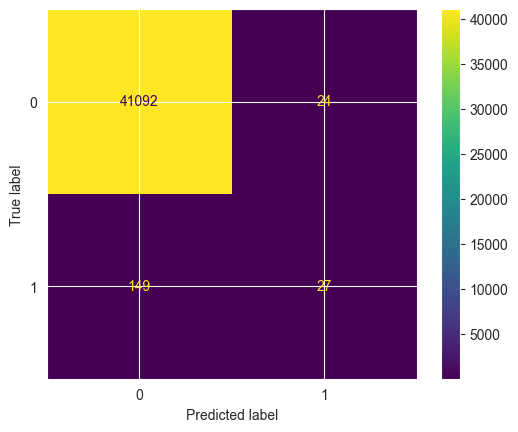

In [30]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

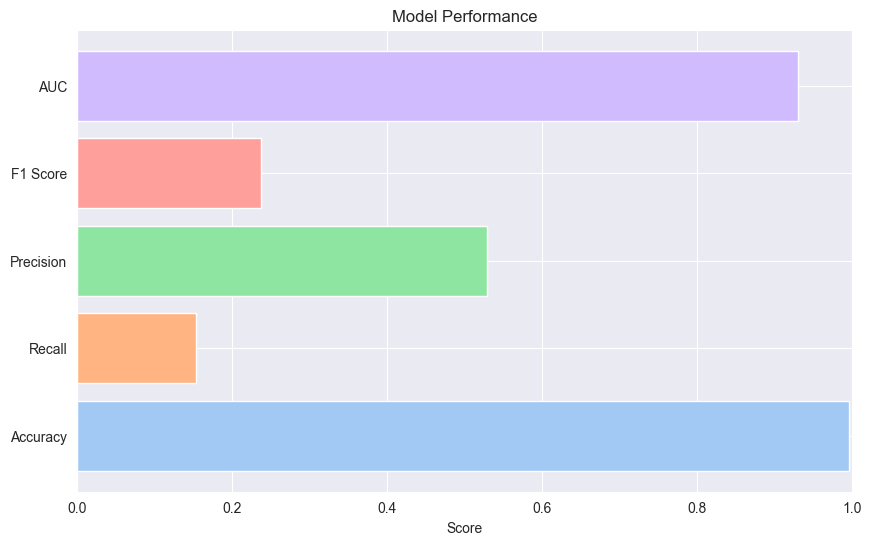

In [31]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [32]:
from sklearn.metrics import average_precision_score, auc

precision2, recall2, threshold = precision_recall_curve(y_test, y_pred_binary)
prauc = auc(precision2, recall2)
print("PRAUC: ", prauc)


PRAUC:  0.3389523245429317


In [33]:
threshold

array([0., 1.])

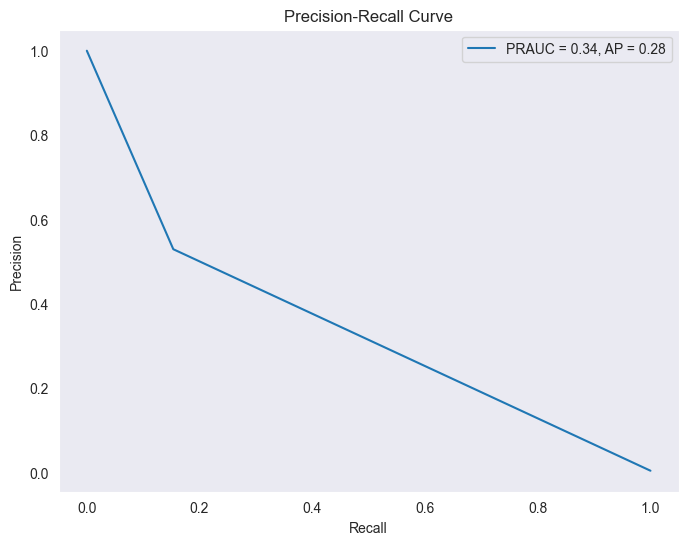

In [34]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall2, precision2, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [35]:
ap

0.28298504274799563

In [36]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
8                     sizelevel        2075
19          net_working_capital        2022
22                 equity_ratio        1948
1                         STInt        1911
20                   debt_ratio        1881
29         receivables_turnover        1823
26               asset_turnover        1754
27           inventory_turnover        1722
17                  quick_ratio        1661
30        day_sales_outstanding        1635
4                liqnonfinlevel        1624
10                          m2b        1591
35           gross_margin_ratio        1568
6                    ni2talevel        1531
2                      dtdlevel        1516
39      interest_coverage_ratio        1494
15              DTDmedianNonFin        1465
23       cashflow_to_debt_ratio        1459
11                        sigma        1446
37                ebitda_margin        1415
21         debt_to_equity_ratio        1393
18                   cash_ratio 

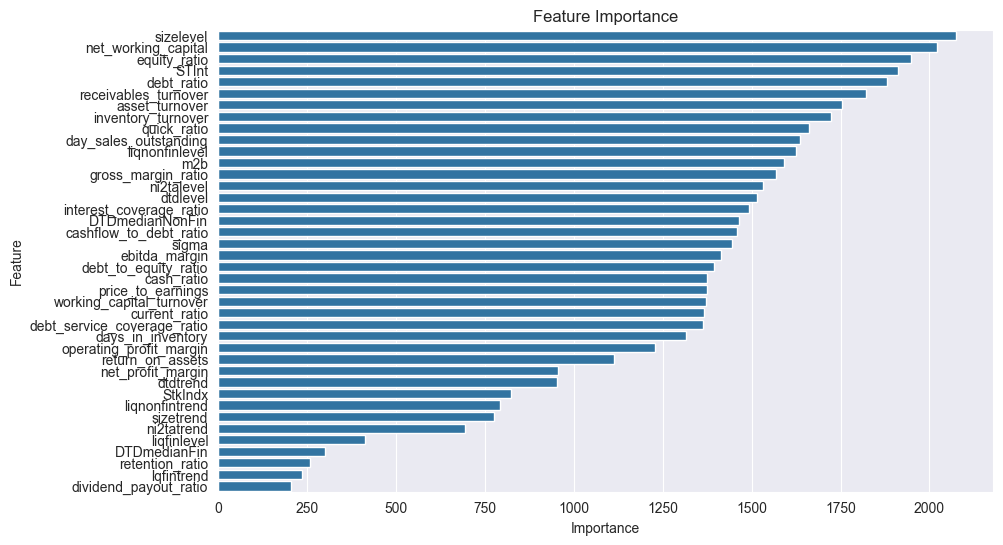

In [37]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

In [38]:
best_params

{'num_leaves': 117,
 'lambda_l1': 0.030318642458893177,
 'lambda_l2': 0.0006952087437386413,
 'feature_fraction': 0.5831815697747286,
 'min_child_samples': 58,
 'learning_rate': 0.019156356355346044,
 'max_depth': 99,
 'num_boost_round': 447,
 'objective': 'binary',
 'metric': 'auc'}